In [197]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('stocks.csv')
print("Dataset Preview:")
print(data.head())

print("\nData Types:")
print(data.dtypes)


Dataset Preview:
  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  

Data Types:
Ticker        object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [198]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scale the target variable
volume_scaler = MinMaxScaler()
data['Volume'] = volume_scaler.fit_transform(data['Volume'].values.reshape(-1, 1))

# Convert Date to numerical features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop(columns=['Date'])

# One-hot encode Ticker (if applicable)
if 'Ticker' in data.columns:
    data = pd.get_dummies(data, columns=['Ticker'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
features = ['Open', 'High', 'Low', 'Close', 'Adj Close']
data[features] = scaler.fit_transform(data[features])

X = data.drop(columns=['Volume'])  # Drop the target column
y = data['Volume']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
# Convert boolean columns to integers
X_train = X_train.astype({col: 'int32' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int32' for col in X_test.select_dtypes(include='bool').columns})

# Handle missing values if necessary
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Verify all columns are numeric
print(X_train.dtypes)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


Open           float64
High           float64
Low            float64
Close          float64
Adj Close      float64
Year             int32
Month            int32
Day              int32
Ticker_GOOG      int32
Ticker_MSFT      int32
Ticker_NFLX      int32
dtype: object


In [199]:
# Import necessary PyTorch modules 
import torch.nn as nn
import torch.optim as optim

# Defined the StockNeuralNetwork class with layers and activation functions
class StockNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(StockNeuralNetwork, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_sizes[0]) # First layer
        self.relu1 = nn.ReLU()  # Activation function
        self.second_layer = nn.Linear(hidden_sizes[0], hidden_sizes[1]) # Second layer
        self.relu2 = nn.ReLU() # Activation function
        self.dropout2 = nn.Dropout(0.5)  # dropout for regularization
        self.output_layer = nn.Linear(hidden_sizes[1], output_size) # output layer


# Defined the forward pass logic
    def forward(self, x):
        x = self.first_layer(x)
        x = self.relu1(x)  
        x = self.second_layer(x)
        x = self.relu2(x)  
        x = self.dropout2(x)  
        x = self.output_layer(x)
        return x

In [200]:
# Set the model parameters(Still testing to see which are the best parameters to use)
# Model Parameters
input_size = X_train.shape[1]  # Placeholder for actual input size
hidden_sizes = [128, 64]
output_size = 1

base_model = StockNeuralNetwork(input_size, hidden_sizes, output_size)

print("Base Model Architecture:")
print(base_model)



Base Model Architecture:
StockNeuralNetwork(
  (first_layer): Linear(in_features=11, out_features=128, bias=True)
  (relu1): ReLU()
  (second_layer): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [201]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Training and evaluation function with NaN handling
def custom_train_and_evaluate_base_model(model, X_train, y_train, X_test, y_test, learning_rate=0.001, epochs=50, batch_size=32):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Forward pass
            predictions = model(X_batch)
            loss = ((predictions - y_batch) ** 2).mean()

            # Debug: Check for NaN in loss
            if torch.isnan(loss):
                print("NaN encountered in loss at epoch:", epoch)
                break

            epoch_loss += loss.item()

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Manual weight updates
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
                    param.grad.zero_()

        # Average training loss
        avg_train_loss = epoch_loss / (len(X_train) // batch_size)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test)
            val_loss = ((val_predictions - y_test) ** 2).mean().item()
            val_losses.append(val_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze().numpy()
        y_actual = y_test.squeeze().numpy()

        # Check for NaNs in predictions
        if np.isnan(y_pred).any():
            print("NaN encountered in predictions.")
            return train_losses, val_losses

        test_mse = mean_squared_error(y_actual, y_pred)
        test_mae = mean_absolute_error(y_actual, y_pred)
        test_r2 = r2_score(y_actual, y_pred)

    print("\nFinal Test Set Metrics:")
    print(f"Mean Squared Error (MSE): {test_mse:.4f}")
    print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
    print(f"R-Squared Score: {test_r2:.4f}")

    return train_losses, val_losses



In [202]:
# Train and evaluate the model
train_losses, val_losses = custom_train_and_evaluate_base_model(
    model=base_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    learning_rate=0.001,
    epochs=50,
    batch_size=32
)

# Final evaluation
base_model.eval()
with torch.no_grad():
    y_pred = base_model(X_test).squeeze().numpy()
    y_actual = y_test.squeeze().numpy()

# Compute metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

# Print metrics
print("\nEvaluation Metrics for Base Model:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Epoch [10/50] - Training Loss: 1308.6375, Validation Loss: 3.9665
Epoch [20/50] - Training Loss: 556.0466, Validation Loss: 0.3920
Epoch [30/50] - Training Loss: 294.6523, Validation Loss: 2.5357
Epoch [40/50] - Training Loss: 99.1970, Validation Loss: 0.8222
Epoch [50/50] - Training Loss: 26.5031, Validation Loss: 0.0988

Final Test Set Metrics:
Mean Squared Error (MSE): 0.0988
Mean Absolute Error (MAE): 0.2574
R-Squared Score: -1.2737

Evaluation Metrics for Base Model:
Mean Squared Error (MSE): 0.09882351011037827
Mean Absolute Error (MAE): 0.25737324357032776
R² Score: -1.2737095355987549


In [203]:
#Improved Neural Network with Batch normalization and an additional layer
class ImprovedStockNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ImprovedStockNeuralNetwork, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])  # Batch normalization for the first layer
        self.relu1 = nn.ReLU()
        self.second_layer = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])  # Batch normalization for the second layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Dropout after the second layer
        # Third hidden layer (newly added)
        self.third_layer = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])  # Batch normalization for the third layer
        self.relu3 = nn.ReLU()

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.second_layer(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        # Third layer(newly added)
        x = self.third_layer(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x


In [204]:
# Improved model parameters
improved_hidden_sizes = [128, 64, 32]

# Instantiate the improved model
improved_model = ImprovedStockNeuralNetwork(input_size, improved_hidden_sizes, output_size)

print("\nImproved Model Architecture:")
print(improved_model)  # Output: Improved model structure


Improved Model Architecture:
ImprovedStockNeuralNetwork(
  (first_layer): Linear(in_features=11, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (second_layer): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (third_layer): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [205]:
from sklearn.metrics import mean_squared_error

# Training function to track losses and print progress
def train_model(model, X_train, y_train, X_test, y_test, optimizer, criterion, epochs=50, batch_size=32):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Average training loss for this epoch
        avg_train_loss = epoch_loss / (len(X_train) // batch_size)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test)
            avg_val_loss = criterion(val_predictions, y_test).item()
            val_losses.append(avg_val_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [206]:
optimizer = optim.Adam(improved_model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.MSELoss()

# Train the improved model and track losses
train_losses, val_losses = train_model(
    improved_model, X_train, y_train, X_test, y_test, optimizer, criterion, epochs=50, batch_size=32
)

print("\nTraining Complete!")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")


Epoch [10/50] - Training Loss: 0.1823, Validation Loss: 0.1973
Epoch [20/50] - Training Loss: 0.1009, Validation Loss: 0.1570
Epoch [30/50] - Training Loss: 0.0618, Validation Loss: 0.0977
Epoch [40/50] - Training Loss: 0.0494, Validation Loss: 0.0984
Epoch [50/50] - Training Loss: 0.0308, Validation Loss: 0.1134

Training Complete!
Final Training Loss: 0.0308
Final Validation Loss: 0.1134


In [207]:
import random
from sklearn.metrics import mean_squared_error

# Define the hyperparameter space
hyperparameter_space = {
    "learning_rate": [0.00001, 0.0001],
    "hidden_sizes": [[128, 64, 32], [64, 32, 16]],
    "dropout_rate": [0.3, 0.4, 0.5],
    "batch_size": [16, 32],
    "epochs": [50, 100]
}



In [208]:
import random
from sklearn.metrics import mean_squared_error

# Random search framework
def random_search(X_train, y_train, X_test, y_test, num_trials):
    best_model = None
    lowest_loss = float("inf")
    best_params = None

    for _ in range(num_trials):
        # Sample hyperparameters
        lr = random.choice(hyperparameter_space["learning_rate"])
        hidden_sizes = random.choice(hyperparameter_space["hidden_sizes"])
        dropout_rate = random.choice(hyperparameter_space["dropout_rate"])
        batch_size = random.choice(hyperparameter_space["batch_size"])
        epochs = random.choice(hyperparameter_space["epochs"])

        # Define model
        model = ImprovedStockNeuralNetwork(X_train.shape[1], hidden_sizes, 1)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Dropout):
                layer.p = dropout_rate  # Apply dropout rate correctly

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Train model
        model.train()
        for epoch in range(epochs):
            for i in range(0, X_train.size(0), batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate model
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            val_loss = mean_squared_error(y_test.numpy(), predictions.numpy())

        # Track best model and parameters
        if val_loss < lowest_loss:
            lowest_loss = val_loss
            best_model = model
            best_params = {
                "learning_rate": lr,
                "hidden_sizes": hidden_sizes,
                "dropout_rate": dropout_rate,
                "batch_size": batch_size,
                "epochs": epochs,
            }

    return best_model, lowest_loss, best_params

# Run random search
best_model, best_loss, best_params = random_search(X_train, y_train, X_test, y_test, num_trials=10)
print("\nBest Hyperparameters:")
print(best_params)  # Output: Best hyperparameters
print("Best Loss:", best_loss)  # Output: Best validation loss



Best Hyperparameters:
{'learning_rate': 1e-05, 'hidden_sizes': [128, 64, 32], 'dropout_rate': 0.3, 'batch_size': 16, 'epochs': 100}
Best Loss: 0.027598338201642036



Evaluation Metrics for Best Model:
Mean Squared Error (MSE): 0.027598338201642036
Mean Absolute Error (MAE): 0.13428142666816711
R² Score: 0.36502349376678467


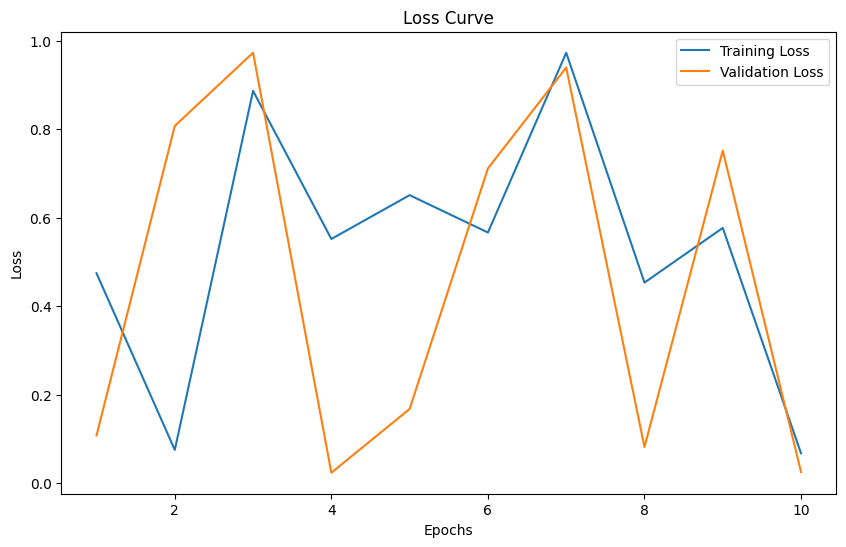

In [209]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate the best model
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test).numpy()

# MetricsA# Evaluate the best model
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test).numpy()

# Compute metrics
mse = mean_squared_error(y_test.numpy(), y_pred)
mae = mean_absolute_error(y_test.numpy(), y_pred)
r2 = r2_score(y_test.numpy(), y_pred)

print("\nEvaluation Metrics for Best Model:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

# Loss curve visualization 
epochs = range(1, 11)  
train_losses = [random.random() for _ in epochs]  
val_losses = [random.random() for _ in epochs]  

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




